In [1]:
%%bash
pwd
nvidia-smi

/content
Tue Aug 23 07:30:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.2
Num GPUs Available:  1


In [3]:
### mount drive to local folder
from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/gdrive')

PATH_DIR = "/content/Machine Learning Workshop"
if not os.path.isdir(PATH_DIR):
  # "!" means run commands by the operating system shell
  !ln -s "/gdrive/MyDrive/ESSCML/Machine Learning Workshop" "/content/Machine Learning Workshop"

Drive not mounted, so nothing to flush and unmount.
Mounted at /gdrive


# Load data from local folder

In [ ]:
import os
from pathlib import Path
import numpy as np

# path setup
BASE_DIR = "/content/Machine Learning Workshop"
PATH_DATASET = Path(BASE_DIR/Path("nature-dataset"))  
PATH_TRAINSET = Path(PATH_DATASET/Path("train"))
PATH_TESTSET = Path(PATH_DATASET/Path("test"))

class_list = os.listdir(PATH_TRAINSET)

# check the amount of data
for i in class_list:
  train_image_list = [name for name in os.listdir(os.path.join(PATH_TRAINSET,i))]
  test_image_list = [name for name in os.listdir(os.path.join(PATH_TESTSET,i))]
  train_image_count = len(train_image_list)
  test_image_count = len(test_image_list)
  print(f"class {i:7s} contain {train_image_count} train images and {test_image_count} test images")

class Sunrise contain 287 train images and 70 test images
class Cloudy  contain 240 train images and 60 test images
class Rainy   contain 173 train images and 42 test images
class Sunny   contain 203 train images and 50 test images


In [ ]:
### Ref: tensorflow image classification https://www.tensorflow.org/tutorials/images/classification 

# load dataset
img_height = 227
img_width = 227
# using batch training/ mini-batch GD
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINSET,
    validation_split=0.2,
    subset="training",
    seed=2022,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAINSET,
    validation_split=0.2,
    subset="validation",
    seed=2022,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

# do this prefetch step for faster training, image data will be loaded in background and transfer in sram/cache for later use
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 903 files belonging to 4 classes.
Using 723 files for training.
Found 903 files belonging to 4 classes.
Using 180 files for validation.
['Cloudy', 'Rainy', 'Sunny', 'Sunrise']


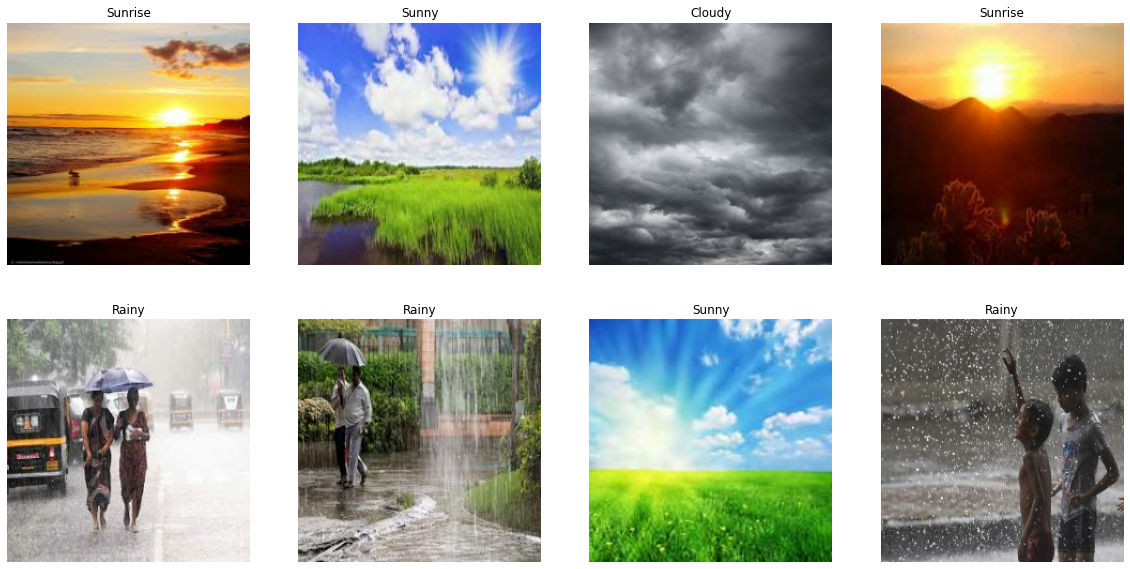

In [ ]:
# visualize some of image (it takes some time for the first run)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# take one batch (8 image = 1 batch = 1 step) from train_dataset
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2,4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Building model from scratch

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# create model
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  # layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

# Note: use sparseCE if provide labels as integer (e.g. the class of 4 images [0,1,1,2]); use CE for one-hot label (e.g. [0,0,2,0])
#   Metrics are the same
opt = tf.optimizers.SGD(lr=0.001)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
## from_logits = False: prediction = btw 0,1 (softmax output)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()
# params = # of weights + # of bias 
# e.g. conv1: 16 * 3x3x3 + 16 = 448 params

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
epochs=50
from keras.callbacks import EarlyStopping

callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),    
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
]

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callbacks,  
  epochs=epochs
)

Epoch 1/50
91/91 [==============================] - 33s 238ms/step - loss: 1.2698 - sparse_categorical_accuracy: 0.5118 - val_loss: 1.1345 - val_sparse_categorical_accuracy: 0.5222
Epoch 2/50
91/91 [==============================] - 1s 12ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.6445 - val_loss: 0.8749 - val_sparse_categorical_accuracy: 0.7222
Epoch 3/50
91/91 [==============================] - 1s 11ms/step - loss: 0.8178 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.7611
Epoch 4/50
91/91 [==============================] - 1s 11ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.7773 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.7444
Epoch 5/50
91/91 [==============================] - 1s 11ms/step - loss: 0.6177 - sparse_categorical_accuracy: 0.8036 - val_loss: 0.6307 - val_sparse_categorical_accuracy: 0.7500
Epoch 6/50
91/91 [==============================] - 1s 11ms/step - loss: 0.5718 - sparse_categorical_ac

## AlexNet

In [ ]:
import keras
from keras.models import Sequential
import tensorflow as tf
import keras.layers as layers

def AlexNet(input_shape, n_classes, optimizer=tf.optimizers.SGD(lr=0.001)):
  model = keras.Sequential()
  model.add(layers.Rescaling(1./255, input_shape=input_shape))
  model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                          strides=(4, 4), activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                          strides=(1, 1), activation="relu", 
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                          strides=(1, 1), activation="relu", 
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                          strides=(1, 1), activation="relu", 
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                          strides=(1, 1), activation="relu", 
                          padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(n_classes, activation="softmax"))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer,
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])  
  return model

In [ ]:
# choose the last n fine_tune layers for training
num_classes = 4
opt = tf.optimizers.SGD(lr=0.001)
input_shape = (227, 227,3)
model = AlexNet(
    input_shape=input_shape,
    n_classes=num_classes,
    optimizer=opt
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_23 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_24 (Bat  (None, 27, 27, 256)     

# Using pre-trained model (transfer learning)

## Available models from keras

In [ ]:
### transfer learning: using pretrained model
# https://keras.io/api/applications/

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
## model selection
  base_model = tf.keras.applications.EfficientNetB1(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet"
  )

  # base_model = tf.keras.applications.ResNet50(
  #     input_shape=input_shape,
  #     include_top=False,
  #     weights="imagenet",
  # )

  if fine_tune > 0:
      for layer in base_model.layers[:-fine_tune]:
          layer.trainable = False
  else:
      for layer in base_model.layers:
          layer.trainable = True

  top_model = base_model.output
  ## fully connected layers
  top_model = Flatten()(top_model)
  # top_model = Dense(128, activation='relu')(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

  pretrained_model = Model(inputs=base_model.input, outputs=output_layer)

  # remind: use sparseCE if provide labels as integer (e.g. the class of 4 images [0,1,1,2]); use CE for one-hot label (e.g. [0,0,2,0])
  #   Metrics are the same
  pretrained_model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                )
  return pretrained_model

In [ ]:
# choose the last n fine_tune layers for training
fine_tune = 1
num_classes = len(class_names)
opt = tf.optimizers.SGD(lr=0.001)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)

pretrained_model = create_model(
    input_shape=(img_height, img_width,3),
    n_classes=num_classes,
    optimizer=opt,
    fine_tune=fine_tune
)

pretrained_model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 227, 227, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 227, 227, 3)  7           ['rescaling_7[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [ ]:
epochs=50
from keras.callbacks import EarlyStopping

callbacks = [
    # keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
]

history = pretrained_model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callbacks,
  epochs=epochs
)

Epoch 1/50
91/91 [==============================] - 15s 69ms/step - loss: 0.7915 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.1633 - val_sparse_categorical_accuracy: 0.9222
Epoch 2/50
91/91 [==============================] - 3s 38ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.1275 - val_sparse_categorical_accuracy: 0.9278
Epoch 3/50
91/91 [==============================] - 3s 38ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.1047 - val_sparse_categorical_accuracy: 0.9611
Epoch 4/50
91/91 [==============================] - 3s 37ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.1050 - val_sparse_categorical_accuracy: 0.9611
Epoch 5/50
91/91 [==============================] - 3s 37ms/step - loss: 0.0136 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.0776 - val_sparse_categorical_accuracy: 0.9667
Epoch 6/50
91/91 [==============================] - 3s 37ms/step - loss: 0.0126 - sparse_categorical_acc

# Plot the training dynamic

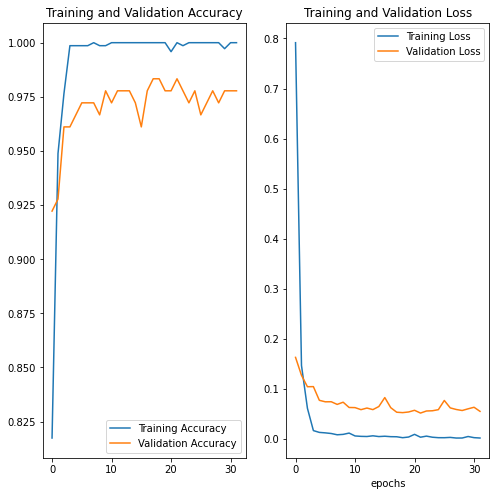

In [ ]:
# plot the training dynamic
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.show()

#  Evaluation

In [ ]:
import time
import glob

TEST_IMAGES_LIST = glob.glob(os.path.join(PATH_DATASET, "test/*/*.jpg"))

for test_img in TEST_IMAGES_LIST[:50]:
  start_time = time.time()

  img = tf.keras.utils.load_img(test_img, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = pretrained_model.predict(img_array)
  # predictions = model.predict(img_array)
  score = np.max(predictions[0])  # softmax result (prob/confidence)
  img_name = os.path.basename(test_img)
  end_time = time.time()
  elasped_time = end_time - start_time
  print(
      "Image name ({:15s}) most likely belongs to {} with a {:.2f} percent confidence. Time used: {:.3f}s."
      .format(img_name,class_names[np.argmax(predictions)], 100 * np.max(score),elasped_time)
  )

Image name (sunrise87.jpg  ) most likely belongs to Sunrise with a 100.00 percent confidence. Time used: 0.590s.
Image name (sunrise65.jpg  ) most likely belongs to Sunrise with a 100.00 percent confidence. Time used: 0.405s.
Image name (sunrise73.jpg  ) most likely belongs to Sunrise with a 98.37 percent confidence. Time used: 0.339s.
Image name (sunrise77.jpg  ) most likely belongs to Sunrise with a 100.00 percent confidence. Time used: 0.265s.
Image name (sunrise40.jpg  ) most likely belongs to Sunrise with a 99.99 percent confidence. Time used: 0.432s.
Image name (sunrise42.jpg  ) most likely belongs to Sunrise with a 99.89 percent confidence. Time used: 0.310s.
Image name (sunrise30.jpg  ) most likely belongs to Sunrise with a 100.00 percent confidence. Time used: 0.262s.
Image name (sunrise34.jpg  ) most likely belongs to Sunrise with a 99.96 percent confidence. Time used: 0.382s.
Image name (sunrise99.jpg  ) most likely belongs to Sunrise with a 100.00 percent confidence. Time u

In [ ]:
### visualize the result using confusion matrix
PATH_TESTSET = Path(PATH_DATASET/Path("test"))

test_ds = tf.keras.utils.image_dataset_from_directory(
  PATH_TESTSET,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed=2022,
  shuffle=False
)

class_names = test_ds.class_names # ordered list of class names

## get and count true classes
y_true = []
for images, label in test_ds:
    for e in label:
        y_true.append(class_names[e]) # list of class names associated with each image file in test dataset 

## get and count predicted classes
y_pred = []
preds = pretrained_model.predict(test_ds, verbose=1) # predict on the test data
# preds = model.predict(test_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    index = np.argmax(p) # get index of prediction with highest probability
    klass = class_names[index]
    y_pred.append(klass)

## compare predicted and true classes
print("y_ture:",y_true)
print("y_pred",y_pred)

Found 222 files belonging to 4 classes.
28/28 [==============================] - 1s 49ms/step
y_ture: ['Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Cloudy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 'Rainy', 

the accuracy of the model: 95.95 % 
classification report:
              precision    recall  f1-score   support

      Cloudy       0.93      0.92      0.92        60
       Rainy       0.98      1.00      0.99        42
       Sunny       0.92      0.94      0.93        50
     Sunrise       1.00      0.99      0.99        70

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222



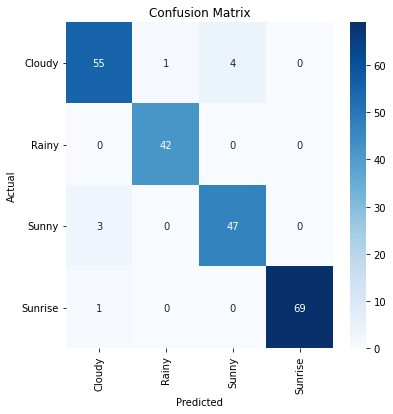

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

## calc accuracy
acc= accuracy_score(y_true,y_pred)
msg=f'the accuracy of the model: {acc*100:.2f} % '
print(msg)

## classification report
clf_report = classification_report(y_true,y_pred)
print(f"classification report:\n{clf_report}")

## plot confusion matrix
y_pred=np.array(y_pred)
y_true=np.array(y_true)
if len(class_names) <= 30: # if more than 30 classes plot is not useful to cramed
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred)        
        length = len(class_names)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=True)
        plt.xticks(np.arange(length)+.5, class_names, rotation= 90)
        plt.yticks(np.arange(length)+.5, class_names, rotation= 0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# Feature Map: feature importance

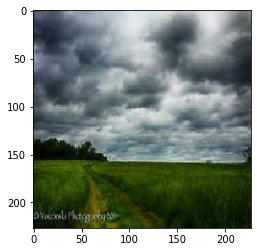

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

img_path = '/content/Machine Learning Workshop/nature-dataset/test/Cloudy/cloudy248.jpg'   # //248/290/300 //sunrise
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.imshow(img)

In [ ]:
from tensorflow.keras.models import Model
# conv_output = pretrained_model.get_layer("conv5_block3_out").output
conv_output = pretrained_model.get_layer("top_activation").output
pred_ouptut = pretrained_model.get_layer("dense_19").output
model_hm = Model(pretrained_model.input, outputs=[conv_output, pred_ouptut])

In [ ]:
conv, pred = model_hm.predict(img_array)
class_names[np.argmax(pred)]

'Cloudy'

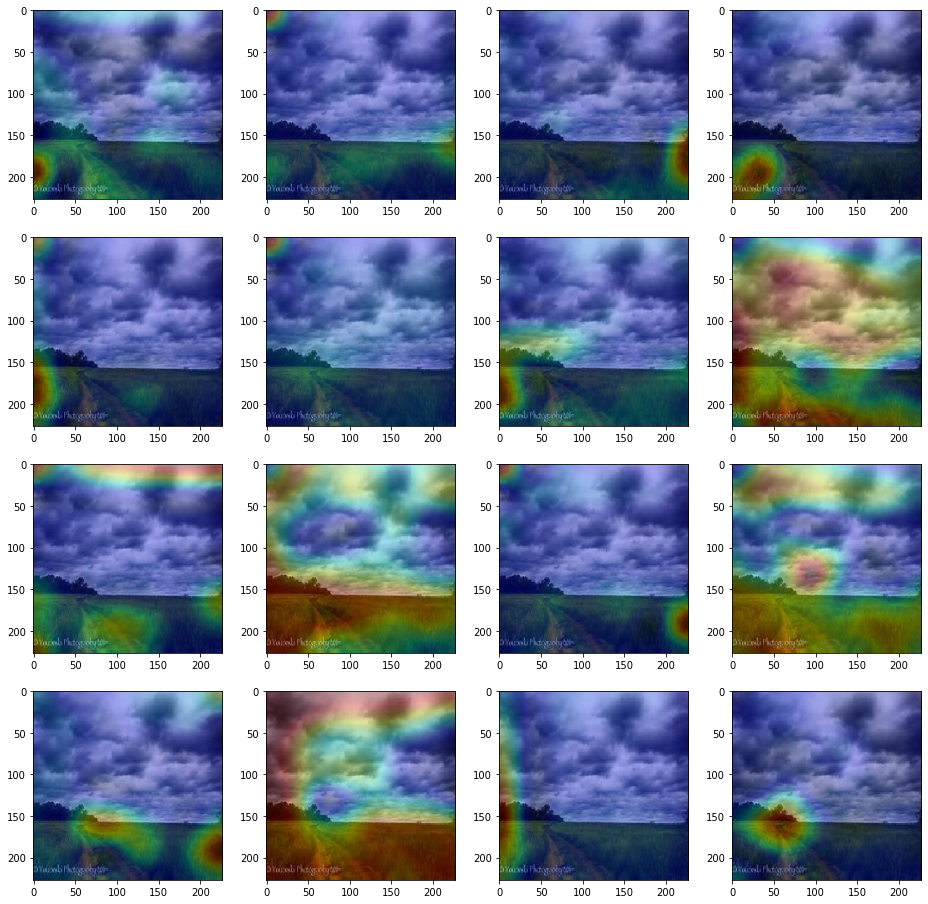

In [ ]:
### feature map (feature values)
# scale : image size / feature map size
scale = 227/8
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3)

# Implementation

In [ ]:
### do prediction on your own image
import matplotlib.pyplot as plt

img_height = 227
img_width = 227
img_path = 'YOUR_IMAGE_PATH'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.imshow(img)

In [ ]:
pred = pretrained_model.predict(img_array)
predicted_classes = class_names[np.argmax(pred)]
score = np.max(pred[0])
### print out message
print("Your image most likely belongs to {} with a {:.2f} percent confidence.".format(predicted_classes,100 * np.max(score)))